<a href="https://colab.research.google.com/github/mhtn-it/6_APP_Project/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Đồ án môn Lập trình song song ứng dụng
**Giảng viên: Thầy Trần Trung Kiên**

## Thông tin nhóm
### STT: Nhóm 6

### Thành viên:
1. 1712258 - Nguyễn Văn Hậu - [kenneth-nguyenn](https://github.com/kenneth-nguyenn)
2. 18120181 - Nguyễn Thị Cẩm Hồng - [chnhgr](https://github.com/chnhgr)
3. 18120216 - Mai Huỳnh Trung Nguyên - [mhtn-it](https://github.com/mhtn-it)

### Tài liệu của nhóm
- Kế hoạch nhóm, phân chia công việc: [Google Sheet](https://docs.google.com/spreadsheets/d/1lNRWbRRnsN0L1bEBLm2tHkauJC2jS9DPZiZfhLQ9Av8/edit?usp=sharing)
- Link Colab thực thi: [Google Colab](https://colab.research.google.com/github/mhtn-it/6_APP_Project/blob/main/Report.ipynb)
- Drive làm việc chung: [Google Drive](https://drive.google.com/drive/folders/1bDjdUTDdbr1EV_9VxSVIOGB60OutJlZi?usp=sharing)

## **Mô tả ứng dụng:** 

### **Mô tả tổng quan:**

**Đề tài**: Thay đổi background ảnh dựa vào phương pháp Poisson Matting

**Input**: 
- Một bức ảnh chân dung
- Trimap của ảnh (được tạo từ một bài toán khác)
- Ảnh nền mới mong muốn

**Output**: 
- Ảnh đã được thay đổi nền

**Ý nghĩa thực tế của ứng dụng**:
- Thay đổi background của ảnh khi cần thiết, ví dụ trong các trường hợp như ảnh kỷ niệm, ảnh thẻ, trang trí...
- Áp dụng trên các phần mềm chỉnh sửa ảnh, trang web chỉnh sửa ảnh online

**Lý do cần tăng tốc**: 
- Toàn bộ quá trình xử lý để cho ra một bức ảnh đúng và chính xác có thể mất đến vài phút (giảm trải nghiệm người dùng)
- Khi xử lý hàng loạt, số lượng lớn thì thời gian sẽ rất lâu

### **Ý tưởng chính của bài toán:**

Từ hình ảnh gốc, trimap, ảnh nền mới ứng dụng sử dụng các biện pháp phủ (matting) và pha trộn (blending) để ghép ảnh chân dung background mới.

![demo](https://github.com/avani17101/Poisson-Matting/raw/main/attachments/result1.png)

Qua nhiều phương pháp cải thiện thì foreground ngày càng chính xác với đối tượng của mình.

![demo2](https://github.com/avani17101/Poisson-Matting/raw/main/attachments/result2.png)

### **Phần nhóm dự định song song hoá:**

Nhóm nhận thấy việc xử lý ảnh có thể song song hoá bằng cách chia nhỏ công việc cho từng pixel. Do đó nhóm dự định sẽ lựa chọn các bước:
- Thao tác matting và blending
- Các bước xử lý để tạo độ chính xác cho foreground

## **Giải quyết bài toán**

### **Phần bổ trợ**

Phần này dùng để tạo cách hàm bổ trợ cho việc thực hiện trên Google Colab. Bao gồm: liên kết Google Colab với Drive, Tạo hàm Python để hỗ trợ đọc file pnm và file ma trận ở notebook, kiểm tra thông tin GPU.

#### Liên kết colab với Google Drive
Để tiết kiệm thời gian load dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Kiểm tra thông tin GPU

In [ ]:
!nvidia-smi

Wed Apr 20 14:42:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Đoạn code tự động lấy 2 con số ứng với compute capability của GPU và lưu vào 2 biến `major` và `minor`:

In [ ]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 3.7


### **Thực thi tuần tự**

#### Quy trình

![Global Matting](https://github.com/mhtn-it/6_APP_Project/blob/main/Data/Report/GlobalMatting.png)

#### Thực hiện

Chuyển vị trí thực thi về thư mục Code

In [ ]:
cd drive/MyDrive/6_APP_Project/Code

/content/drive/MyDrive/6_APP_Project/Code


Import thư viện

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../Data"
import time
import scipy
from scipy.optimize import fmin

#### Các hàm đọc ảnh và cải thiện trimap

Hàm biểu diễn một mảng các ảnh thành biểu đồ

In [ ]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    """
    Hàm biểu diễn một mảng các ảnh thành biểu đồ

    Parameters:
    -----------
    img_arr : Mảng numpy đại diện cho các ảnh
    r: Số dòng của đồ thị
    c: Số cột của đồ thị
    dim: Kích thước của một ảnh
    titles_arr: Tiêu đề của mỗi ảnh
    """
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

Hàm đọc tất cả ảnh trong một folder

In [ ]:
def read_img(im_names,path=IMAGES_FOLDER_PATH):
    """
    Hàm đọc tất cả ảnh trong một folder

    Parameters:
    -----------
    im_names: Tên của file ảnh trong thư mục ảnh

    Return:
    -----------
    Hai mảng numpy chứa tập ảnh có kích thước bằng nhau ở dạng RGB và Grayscale
    """
    im = []
    im_gray = []
    for name in im_names:
        img =  cv2.imread(path+'/'+name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if(len(im)>=1):
            img = cv2.resize(img,(im[0].shape[1],im[0].shape[0]))
        im.append(img)
        im_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return im, im_gray

Hàm cải thiện độ chính xác của ảnh Trimap 

(Ảnh trimap gốc có được tạo bởi một CNN, chi tiết phương pháp [tại đây](https://www.researchgate.net/publication/319575172_Automatic_skin_and_hair_masking_using_fully_convolutional_networks))


In [ ]:
img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+'tri3.png',0)

def gen_tri(img,iters):

    """
    Hàm cải thiện độ chính xác của ảnh Trimap

    Parameters:
    -----------
    img: Tên của file ảnh trimap

    Return:
    -----------
    Trimap đã được cải thiện
    """

    kernel = np.ones((5,5),np.uint8)
    tri = cv2.erode(img,kernel,iterations = iters)

    for i in range(tri.shape[0]):
        for j in range(tri.shape[1]):
            if(tri[i][j]!=255 and tri[i][j]!=0):
                tri[i][j] = 127
    return tri

Hiển thị các ảnh gốc, grayscale, trimap và background mới trong một đồ thị.

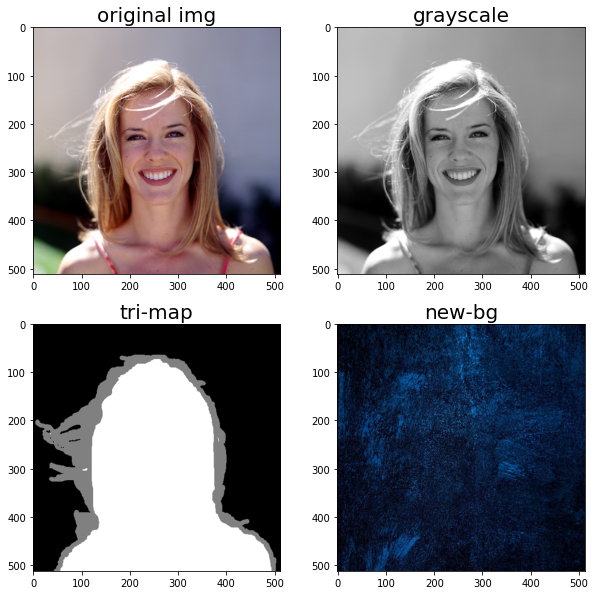

In [ ]:
img = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img3.png'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'img3.png'),0)
tri = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'tri3.png'),0)

new_bg = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'new_bg3.png'))
new_bg = cv2.cvtColor(new_bg, cv2.COLOR_BGR2RGB)
new_bg = cv2.resize(new_bg, (img.shape[1],img.shape[0])) 

display_img_arr([img,img_gray,tri,new_bg], 2,2,(10,10), ['original img','grayscale','tri-map','new-bg'])

#### Global Matting

Phương trình Poisson
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
trong đó, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
là một toán tử Laplacian and toán tử vector div của Gradient ảnh input đối với hiệu của Foreground và Background.


Phương trinh Poisson được giải bằng phương pháp ước lượng Gauss Siedel Iteration

cho,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)}) + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$
với $\beta$ nằm trong đoạn (1,2)

Tìm hiểu thêm về phương trình Poisson [tại đây](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/poissonmatting_siggraph04.pdf) và [đây](http://www.cse.cuhk.edu.hk/~leojia/all_final_papers/matting_siggraph04.pdf).


Hàm tạo mask để phân vùng Background và Foreground của ảnh trimap và ảnh input ở dạng grayscale

In [ ]:
def calc_masks(tri, img_gray):
    """
    Hàm tạo mask để phân vùng Background và Foreground của ảnh trimap

    Parameters:
    -----------
    tri: mảng numpy đại diện cho ảnh trimap ở dạng grayscale
    img_gray: mảng numpy đại điện cho ảnh phiên bản grayscale

    Return:
    -----------
    Danh sách các mảng numpy đại diện cho: foreground mask, foreground image, background mask,
    background image, unknown region mask,unknown region image
    """
    mask_bg = (tri<10)
    mask_fg = (tri>245)
    mask_unknown = (np.bitwise_and(tri>=10,tri<=245))

    fg = img_gray*(mask_fg)
    bg = img_gray*(mask_bg)
    unknown = img_gray*mask_unknown
    return [mask_fg,fg,mask_bg,bg,mask_unknown,unknown], ['fg mask','fg','bg mask','bg','mask unknown','unkown reg img']

Hàm tính đạo hàm cấp hai phục vụ cho phương trình Poisson

In [ ]:
def doubleDifferential(img, factor):
    """
    Hàm tính đạo hàm bậc hai phục vụ cho phương trình Poisson

    Parameters:
    -----------
    img: mảng numpy đại diện cho ảnh inpu grayscale
    factor: một hằng số dùng để chia vi phân cấp nhất trước khi tính vi phân cấp 2. 
            Factor có thể là một hằng hoặc một mảng numpy bằng kích thước của ảnh.

    Return:
    -----------
    Hai mảng numpy đại điện cho vi phân cấp hai tương ứng với Y và X.
    """
    dy, dx = np.gradient(img)
    d2y, _ = np.gradient(dy/factor)
    _, d2x = np.gradient(dx/factor)
    return d2y, d2x

Hàm tìm xấp xỉ vùng Background và Foreground

In [ ]:
def fb(img_gray,mask_fg,mask_bg,mask_unknown):
    """
    Hàm tìm xấp xỉ vùng Background và Foreground

    Parameters:
    -----------
    img_gray,mask_fg,mask_bg,mask_unknown: lần lượt là mảng numpy đại diện cho ảnh input grayscale,
                                           vùng Foreground, vùng Background, vùng chưa xác định

    Return:
    -----------
    Hai mảng numpy đại điện cho xấp xỉ vùng Background và Foreground.
    """
    F = img_gray*(mask_fg+mask_unknown)
    B = img_gray*(mask_bg+mask_unknown)
    return F, B

Hàm thực thi global alpha matting

In [ ]:
def global_alpha_matting(alpha,d2alpha,unknown_seg,iters = 50, threshold = 0.1, beta = 1):
    """
    Hàm thực thi global alpha matting

    Parameters:
    -----------
    alpha: giá trị xấp xỉ của alpha
    d2alpha: tổng đạo hàm riêng bậc 2 của alpha theo X và Y
    unknown_seg: mảng munby đại diện cho vùng chưa xác định rõ
    iters: số lần chạy của phương pháp ước lượng Gauss Siedel
    threshold: ngưỡng cho sự thay đổi sau mỗi lần chạy. Nếu dưới ngưỡng thì phương trình sẽ dừng lại
    beta: nhân tử beta của phương pháp ước lượng Gauss Siedel

    Return:
    -----------
    Mảng numpy đại diện cho chỉ số matte đã được tạo và thời gian thực thi
    """
    tic = time.time()
    prev_alpha = np.zeros(alpha.shape)
    diff = np.sum(np.abs(prev_alpha-alpha))
    
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])
    tac = time.time()                    
    return alpha, tac-tic

Hàm tính Gradient của ảnh input

In [ ]:
def grads(F,B,mask_fg,img_gray,mask_unknown):
    """
    Hàm tính Gradient của ảnh input

    Parameters:
    -----------
    F,B,mask_fg,img_gray,mask_unknown: lần lượt là mảng numpy đại diện cho vùng xấp xỉ của Foreground, 
                                        Background, mask fg, ảnh input grayscale, mask_unknow

    Return:
    -----------
    Mảng numpy đại diện cho xấp xỉ alpha
    Mảng numpy đại diện cho đạo hàm bậc hai của alpha
    Mảng numby đại diện cho sự khác nhau của xấp xỉ giữa Foreground và Background
    """
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha, d2alpha, diff

Hàm tính xấp xỉ alpha

In [ ]:
def func_estimate_alpha(tri, img_gray):
    """
    Hàm tính xấp xỉ alpha

    Parameters:
    -----------
    tri: ảnh trimap
    img_grayscale: ảnh input ở phiên bản grayscale

    Return:
    -----------
    Xấp xỉ alpha, Foreground, BackGround, đạo hàm bậc 2 của alpha, 
    Danh sách các biến đầu vào đã xử lý của input, sự khác biệt của F và B
    """
    imgs, titles = calc_masks(tri, img_gray)
    display_img_arr(imgs, 3,2,(10,10),titles)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    
    F,B = fb(img_gray,mask_fg,mask_bg,mask_unknown)
    display_img_arr([F,B], 1,2,(10,10),['F','B'])
#     print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img_gray.shape)
    est_alpha, d2alpha, diff =  grads(F,B,mask_fg,img_gray,mask_unknown)
    return est_alpha, F, B, d2alpha, imgs, diff

Hàm tổng hợp bước matting

In [ ]:
def matting_combined(tri, img_gray):
    """
    Hàm tổng hợp bước matting

    Parameters:
    -----------
    tri: ảnh trimap
    img_gray: ảnh input dạng grayscale

    Return:
    -----------
    Một từ điển chứa thông tin về matting của bức ảnh: alpha, F, B, diff, vùng chưa xác định, vùng chưa xác định của trimap
    """
    estimate_alpha, F, B, d2alpha, imgs, diff = func_estimate_alpha(tri, img_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    alpha, _ = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown)
    alpha = np.minimum(np.maximum(alpha,0),1)

    return {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}


Thực thi bước matting

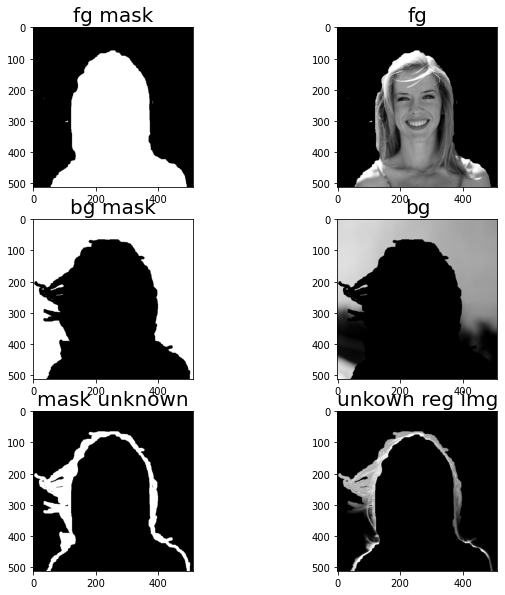

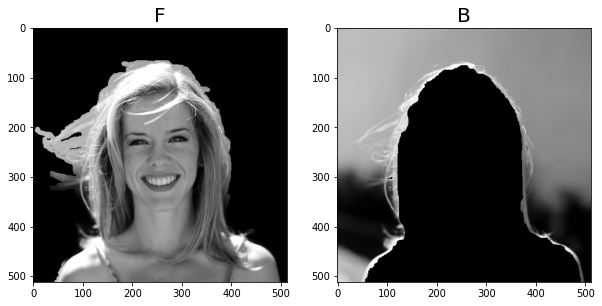

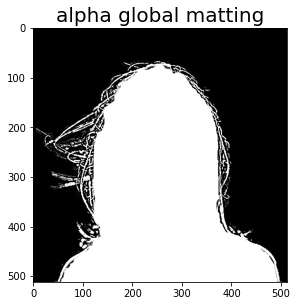

In [ ]:
all_data = matting_combined(tri, img_gray)

# Bổ sung loại hình ảnh vào all_data
all_data.update({'img': img, 'img_gray': img_gray})

all_data_3 = all_data.copy()

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

#### Alpha Blending

In [ ]:
def alpha_blend(new_bg,alpha,img):
    """
    Hàm thực thi alpha_blend

    Parameters:
    -----------
    new_bg: một mảng numpy đại diện cho background mới (có màu)
    alpha: mảng numpy đại diện cho các chỉ số alpha dùng để matte
    img: bức ảnh gốc

    Return:
    -----------
    Một bức ảnh mới đã đổi background
    """
    new_img = np.zeros(new_bg.shape)
    new_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)*new_bg[:,:,0]
    new_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)*new_bg[:,:,1]
    new_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)*new_bg[:,:,2]
    return np.int64(new_img)

Xem kết quả thay đổi background

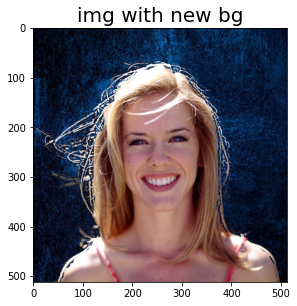

In [ ]:
new_img = alpha_blend(new_bg,all_data['alpha'],img)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

alpha = all_data['alpha']
new_img_global = alpha_blend(new_bg,alpha,img )

Những phần sẽ hoàn thiện trong tương lai:

*   Cải thiện độ chính xác của những vùng không xác định bằng các phương pháp khác: local poisson matting, refinement image,...
*   Song song hoá quá trình xử lý các pixel của ảnh.
*   Tìm hiểu thêm về việc tạo trimap





## Nhìn lại quá trình làm đồ án

**1712898 - Nguyễn Văn Hậu**
- Khó khăn
    + 
    + 
    + 
- Học được:
    + 
    + 

**18120181 - Nguyễn Thị Cẩm Hồng**
- Khó khăn
    + 
    + 
    + 
- Học được:
    + 
    + 

**18120216 - Mai Huỳnh Trung Nguyên**
- Khó khăn
    + 
    + 
    + 
- Học được:
    + 
    + 
    + 

**Nhóm**: 
- Khó khăn:
  + 
  + 
  + 
- Do đó, nếu có thêm thời gian nhóm sẽ cố gắng thực hiện:
  + 
  + 
  + 


## Tài liệu tham khảo

- Project: Poisson Matting, [github](https://github.com/avani17101/Poisson-Matting).
- Paper: Poisson Matting của Juan Sun, Jiaya Jia, Chi-Keung Tang, Heung-Yeung Shum, [paper](http://www.cse.cuhk.edu.hk/~leojia/all_final_papers/matting_siggraph04.pdf)